# ANT VS BEE

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [182]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [183]:
data_dir = "../Dataset"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [184]:
class_names = train_dataset.classes
print("Clases: ", class_names)

Clases:  ['ants', 'bees']


In [185]:
def imshow(inp, title=None):
    """Mostrar imagen tensor transformada"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

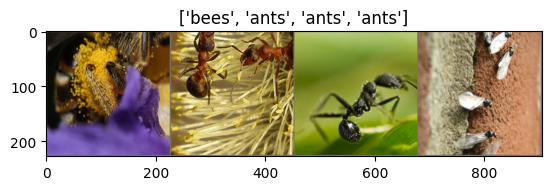

In [186]:
inputs, classes = next(iter(train_loader))
out = utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])


In [187]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout1 = nn.Dropout(p=0.5)  
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(p=0.5)  
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = self.fc3(x)
        return x


In [188]:
SimpleCNN()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=2, 

In [189]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


In [190]:
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Linear-13                  [-1, 512]      25,690,624
          Dropout-14                  [

In [191]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [192]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
   
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            
            optimizer.zero_grad()

           
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            
            loss.backward()
            optimizer.step()

           
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

       
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)  
        train_accuracies.append(epoch_acc) 

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

       
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

       
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_losses.append(val_loss) 
        val_accuracies.append(val_acc)  
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/10
----------
Train Loss: 0.7412 Acc: 0.4959
Val Loss: 0.6901 Acc: 0.5425
Epoch 2/10
----------
Train Loss: 0.6893 Acc: 0.5205
Val Loss: 0.6884 Acc: 0.5425
Epoch 3/10
----------
Train Loss: 0.6540 Acc: 0.6230
Val Loss: 1.0396 Acc: 0.5294
Epoch 4/10
----------
Train Loss: 0.7153 Acc: 0.5533
Val Loss: 0.6734 Acc: 0.5621
Epoch 5/10
----------
Train Loss: 0.6672 Acc: 0.6025
Val Loss: 0.6848 Acc: 0.5686
Epoch 6/10
----------
Train Loss: 0.6490 Acc: 0.5861
Val Loss: 0.6455 Acc: 0.5948
Epoch 7/10
----------
Train Loss: 0.6067 Acc: 0.6311
Val Loss: 0.7596 Acc: 0.6013
Epoch 8/10
----------
Train Loss: 0.6614 Acc: 0.6352
Val Loss: 0.5949 Acc: 0.6209
Epoch 9/10
----------
Train Loss: 0.6304 Acc: 0.6189
Val Loss: 0.6419 Acc: 0.6340
Epoch 10/10
----------
Train Loss: 0.5989 Acc: 0.6393
Val Loss: 0.6345 Acc: 0.6144


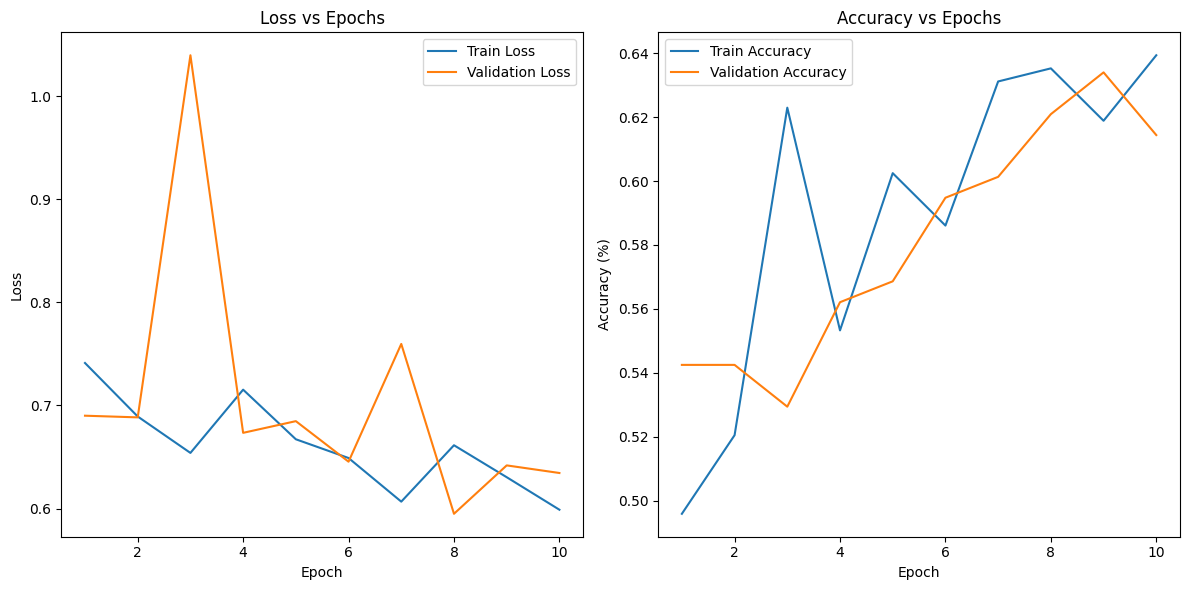

In [193]:

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')  
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Graficar las precisiones de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), [acc.cpu().numpy() for acc in train_accuracies], label='Train Accuracy')  # Transfer a CPU y conver a NumPy
plt.plot(range(1, 11), [acc.cpu().numpy() for acc in val_accuracies], label='Validation Accuracy')  # Transfer a CPU y conver a NumPy
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()



In [194]:
torch.save(model.state_dict(), 'bee_ant_classifier.pth')
print("Modelo guardado como 'bee_ant_classifier.pth'")

Modelo guardado como 'bee_ant_classifier.pth'


C:\Users\Frank Prime\AppData\Local\Temp\ipykernel_26864\1993001353.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bee_ant_classifier.p

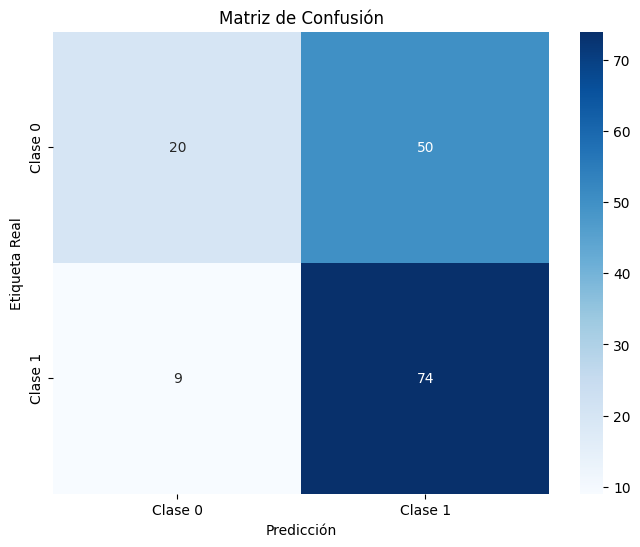

In [195]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


model = SimpleCNN()  
model.load_state_dict(torch.load('bee_ant_classifier.pth'))
model.to(device)  

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


In [198]:
from PIL import Image
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Cargar la imagen
image_path = 'test/bee.jpg'  
image = Image.open(image_path)


input_image = transform(image).unsqueeze(0)  
input_image = input_image.to(device)  

model.eval()  
with torch.no_grad():
    outputs = model(input_image)
    _, preds = torch.max(outputs, 1)

class_names = ['Ant', 'Bee'] 
predicted_class = class_names[preds.item()]
print(f'La predicción para la imagen es: {predicted_class}')


La predicción para la imagen es: Bee
